In [55]:
import pandas as pd

In [56]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

week_nums = [190406, 190413, 190420, 190427, 190504, 190511, 190518, 190525, 190601, 190608, 190615, 190622, 190629, 190706, 190713, 190720, 190727]       
#week_nums = [190601, 190608, 190615, 190622, 190629, 190706, 190713, 190720, 190727, 190803, 190810, 190817, 190824, 190831, 190907, 190914, 190921, 190928]
#week_nums = [190601, 190608, 190615]
df = get_data(week_nums)

In [57]:
#clean column names
df.rename(columns={'C/A': 'c_a', 'UNIT': 'unit', 'SCP': 'scp', 'STATION': 'station', 'LINENAME': 'linename', 'DIVISION': 'division', 'DATE': 'date','TIME': 'time', 'DESC': 'desc', 'ENTRIES': 'entries', df.columns[10]: 'exits'}, inplace=True)

#keep only subway divisions
df = df[(df['division'] == 'BMT') | (df['division'] == 'IND') | (df['division'] == 'IRT')]

#Add formatted timestamp column
df['timestamp'] = pd.to_datetime(df['date'] + " " + df['time'])

#add unique turnstile id
df['unique_turnstile_id'] = df['c_a'] + df['unit'] + ' ' + df['station'] + ' ' + df['scp']

#add day of week column
df['day_of_week'] = df.timestamp.dt.day_name()

df = df.reset_index()

In [58]:
#df.desc.value_counts()

In [59]:
# Get rid of duplicate entries caused by "RECOVER AUD" in desc column, if any
df.sort_values(["c_a", "unit", "scp", "station", "timestamp"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["c_a", "unit", "scp", "station", "timestamp"], inplace=True)

In [67]:
df_23st = df[df['station'] == '47-50 STS ROCK']
df_23st.linename.unique()

array(['BDFM'], dtype=object)

In [61]:
# df_23st = df[df['station'] == '23 ST']
# df_23st.linename.unique()

In [62]:
# df_23st = df[(df['station'] == '34 ST-HERALD SQ') &
#                 (df['linename'] == '123ACE')]
# df_23st.division.unique()

In [63]:
# df_subset = df[(df['station'] == '23 ST') |
#                 (df['station'] == 'AVENUE X')]
# df_subset.linename.unique()

In [68]:
def rename_station(row):
    if row.station == '23 ST' or row.station == '86 ST' or row.station == '125 ST' or row.station == '59 ST' or row.station == '96 ST' or row.station == '14 ST':
        row.station = row.station + ' ' + row.linename
    return row

In [38]:
#df_subset = df_subset.apply(rename_station, axis='columns')

In [39]:
# #df_23st = df_subset[df_subset['station'] == '23 ST']
# df_subset.station.unique()

In [69]:
df = df.apply(rename_station, axis='columns')

In [70]:
#keep only needed columns
df = df.loc[:,['station', 'entries', 'exits', 'timestamp', 'unique_turnstile_id']]

In [71]:
#calculate actual volumes for each record (record minus previous record)
df['diff_entries'] = abs(df.entries.diff())
df['diff_exits'] = abs(df.exits.diff())
df['total_traffic'] = df.diff_entries + df.diff_exits

#record index in new column (needed to identify first instance of turnstile data)
df['record_index'] = df.index
#df

In [72]:
#identify first rows of unique turnstile data
df_first_rows = df.groupby('unique_turnstile_id').first()

#index of records of first turnstile rows
list_index = df_first_rows.record_index.values

#drop first rows from main df
df.drop(list_index, inplace=True)

In [73]:
df.shape

(3240790, 9)

In [74]:
#keep only data with traffic > 0 amd < 14400 (1 person per second)
df = df[(df['total_traffic'] > 0) & (df['total_traffic'] < 14400)]

In [75]:
df.shape

(2843433, 9)

In [76]:
df = df.reset_index()

#### **This was changed from previous version:**

In [77]:
#drop record index column. no longer applies after re-indexing
df.drop(['record_index', 'entries', 'exits'], axis=1, inplace=True)

In [78]:
df["weekday"] = df["timestamp"].dt.day_name()

In [79]:
# #filter for only Penn Station
# df_penn = df[df['station'] == '34 ST-PENN STA']
# df_penn

In [80]:
# df_penn_grouped = df_penn.groupby(['station', 'weekday'])
# df_penn_grouped

In [81]:
df_by_station = df.groupby("station").agg({"total_traffic": 'sum'}).reset_index().sort_values(by="total_traffic", ascending=False)
#df_by_station.head(10)

In [82]:
# df_by_station_alt = df.groupby(["station", pd.Grouper(key="timestamp", freq = "D")]).agg({'total_traffic': 'sum'}).sort_values(by="total_traffic", ascending=False)
# df_by_station_alt
#df_by_station.reset_index()

In [84]:
df_by_station.head(10)

,station,total_traffic
69,34 ST-PENN STA,33322393.0
245,GRD CNTRL-42 ST,29065257.0
67,34 ST-HERALD SQ,25012557.0
349,TIMES SQ-42 ST,20961309.0
19,14 ST-UNION SQ,20533165.0
76,42 ST-PORT AUTH,19969747.0
238,FULTON ST,18241509.0
187,CANAL ST,14546518.0
94,59 ST COLUMBUS,13759907.0
80,47-50 STS ROCK,12041838.0


In [472]:
#df_by_station_alt.groupby('station').apply(lambda df: df.loc[df.total_traffic.idxmax()]).sort_values(by='total_traffic', ascending=False)

In [85]:
df_top_stations = df_by_station.groupby('station').apply(lambda df: df.loc[df.total_traffic.idxmax()]).sort_values(by='total_traffic', ascending=False)

In [86]:
top10_list = list(df_top_stations.head(10).index)

In [87]:
top10_list

['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 'TIMES SQ-42 ST',
 '14 ST-UNION SQ',
 '42 ST-PORT AUTH',
 'FULTON ST',
 'CANAL ST',
 '59 ST COLUMBUS',
 '47-50 STS ROCK']

In [88]:
df_by_station = df.groupby(["station", "weekday"]).agg({'total_traffic': 'sum'}).reset_index().sort_values(by="total_traffic", ascending=False)
df_by_station

,station,weekday,total_traffic
489,34 ST-PENN STA,Wednesday,5738987.0
488,34 ST-PENN STA,Tuesday,5698597.0
487,34 ST-PENN STA,Thursday,5639291.0
483,34 ST-PENN STA,Friday,5389296.0
484,34 ST-PENN STA,Monday,5317194.0
...,...,...,...
2195,ORCHARD BEACH,Thursday,1396.0
2197,ORCHARD BEACH,Wednesday,282.0
2191,ORCHARD BEACH,Friday,232.0
2192,ORCHARD BEACH,Monday,197.0


In [89]:
df_top10_byday = df_by_station.loc[df_by_station['station'].isin(top10_list)]
df_top10_byday

,station,weekday,total_traffic
489,34 ST-PENN STA,Wednesday,5738987.0
488,34 ST-PENN STA,Tuesday,5698597.0
487,34 ST-PENN STA,Thursday,5639291.0
483,34 ST-PENN STA,Friday,5389296.0
484,34 ST-PENN STA,Monday,5317194.0
...,...,...,...
1312,CANAL ST,Sunday,1226533.0
661,59 ST COLUMBUS,Sunday,1152338.0
1669,FULTON ST,Sunday,980915.0
562,47-50 STS ROCK,Saturday,713437.0


In [92]:
import seaborn as sns

#traffic = sns.load_dataset("traffic")
top10_pivot = df_top10_byday.pivot("station", "weekday", "total_traffic")
top10_pivot = top10_pivot[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]


top10_pivot.loc['34 ST-PENN STA','order'] = 1
top10_pivot.loc['GRD CNTRL-42 ST','order'] = 2
top10_pivot.loc['34 ST-HERALD SQ','order'] = 3
top10_pivot.loc['TIMES SQ-42 ST','order'] = 4
top10_pivot.loc['14 ST-UNION SQ','order'] = 5
top10_pivot.loc['FULTON ST','order'] = 6
top10_pivot.loc['FULTON ST','order'] = 7
top10_pivot.loc['CANAL ST','order'] = 8
top10_pivot.loc['59 ST COLUMBUS','order'] = 9
top10_pivot.loc['47-50 STS ROCK','order'] = 10

top10_pivot = top10_pivot.sort_values(by='order')
top10_pivot.drop('order', axis=1, inplace=True)
top10_pivot

weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
station,,,,,,,
34 ST-PENN STA,5317194.0,5698597.0,5738987.0,5639291.0,5389296.0,2994394.0,2544634.0
GRD CNTRL-42 ST,4909459.0,5314691.0,5309667.0,5198165.0,4747073.0,2015509.0,1570693.0
34 ST-HERALD SQ,3886188.0,4162325.0,4270606.0,4148644.0,4099599.0,2491850.0,1953345.0
TIMES SQ-42 ST,3116497.0,3484264.0,3584389.0,3462651.0,3359119.0,2243815.0,1710574.0
14 ST-UNION SQ,3096709.0,3384861.0,3485136.0,3307983.0,3324124.0,2249802.0,1684550.0
FULTON ST,3037897.0,3318441.0,3304913.0,3254168.0,3034866.0,1310309.0,980915.0
CANAL ST,2200114.0,2360620.0,2398904.0,2388111.0,2349851.0,1622385.0,1226533.0
59 ST COLUMBUS,2115085.0,2287441.0,2358355.0,2274668.0,2116554.0,1455466.0,1152338.0
47-50 STS ROCK,2043765.0,2233325.0,2259066.0,2191561.0,2045411.0,713437.0,555273.0


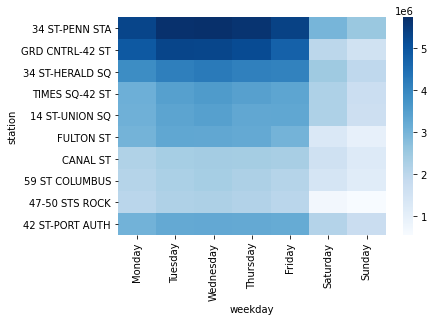

In [93]:
ax = sns.heatmap(top10_pivot, cmap="Blues")

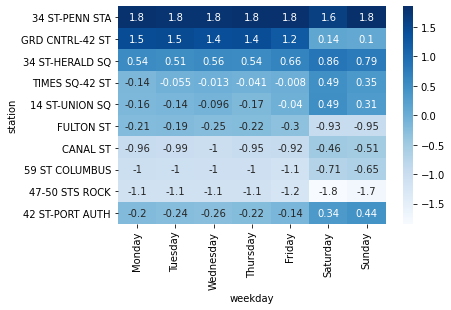

In [94]:
df_norm_col=(top10_pivot-top10_pivot.mean())/top10_pivot.std()

ax = sns.heatmap(df_norm_col, cmap="Blues", annot=True)

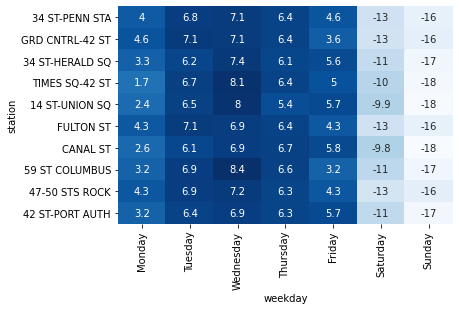

In [95]:
# Normalize it by row:
# (not sure if it is the best way, please feel free to give me a better method.)
# 1: substract mean
df_norm_row=top10_pivot.sub(top10_pivot.mean(axis=1), axis=0)
# 2: divide by standard dev
df_norm_row=df_norm_row.div(top10_pivot.std(axis=1), axis=0)
df_norm_row=df_norm_row.mul(10, axis=0)

ax = sns.heatmap(df_norm_row, cmap="Blues", annot=True, cbar=False)

In [96]:
df_by_station.total_traffic.sum()

1014179504.0

In [100]:
df_top_stations.iloc[5:6].total_traffic.sum() / df_by_station.total_traffic.sum()

0.019690544840669545